In [1]:
import numpy as np
import matplotlib.pyplot as plt
import my_plot as my_plt
import my_pow_funcs as pf
import my_mashin_func as mf

## 52 корня и степени
1. Обьясните, чем отличаются два рассмотренных примера? Почему настолько отличается точность вычислений?
2. Предложите альтернативный способвычислений, который будет находить 52 корня из данного числа с такой точностью, что последующее возведение в квадрат 52 раза будет давать исходное число с относительной погрешностью близкой к машинной точности. 

### Решение
1. Для первого случая мы считали сначала 52 корня, а после возводили 52 раза в квадрат. При таком решении ошибка будет накапливаться сначала 52 раза для корня, а после 52 раза для квадрата.
При попеременном возведении в квадрат и взятие корня, мы компенсируем ошибку этими двумя операциями на каждом шаге.

2. Два альтернативных способа для решения.


2.1 Найте значение через логарифм. Возьмем логарифм от возведения 52 раза в квадрат $x^{2^{52}} \rightarrow 2^{52}\log{x}$, после поделим на $2^{52}$ это эквивалентно взятию корня. В итоге возьмем экспоненту от получившегося и получим результат $\exp(\frac{2^{52}}{2^{52}}\log{x}) = result$.

Сгенерируем данные и построим график относительной погрешности.

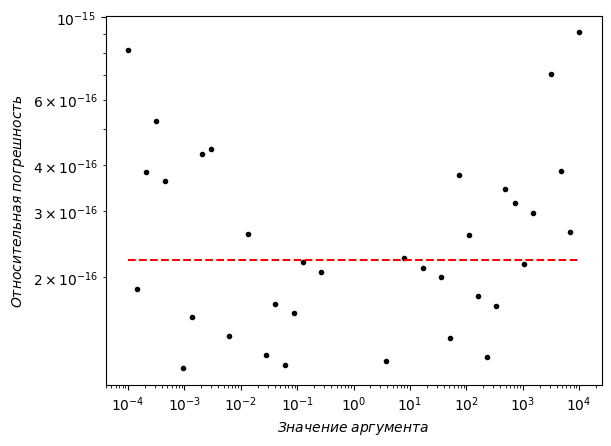

In [10]:
def relative_error(x0, x):
    err = np.abs(x0 - x) / abs(x0)
    return err

# create all data
x0 = np.logspace(-4, 4, dtype = np.double)
x = pf.make_many_sqrt_pow_by_log(x0, 52)
err = relative_error(x0, x)

# plotting
my_plt.plot_error_loglog(x0, err)

2.2 Сделаем реализацию собственных чисел с плавающей запятой, чтобы описать операции при числах с малой величеной после запятой и величеной до запятой равной 1. 

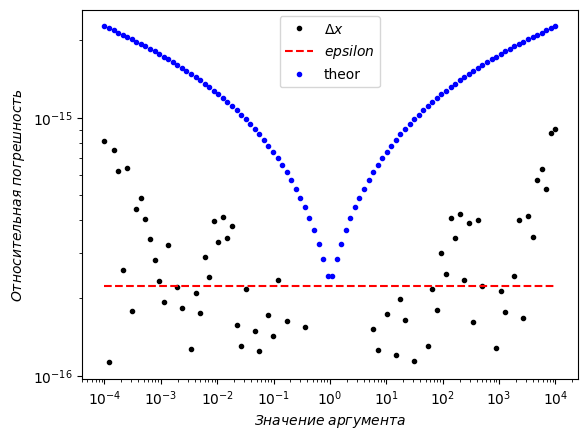

In [13]:

# make a class
class LogNumber(object):
    def __init__(self, zeta):
        self.zeta=zeta
    def __str__(self):
        return "{}".format(self.to_float())
    @staticmethod
    def from_float(x):
        return LogNumber(np.log(x))
    def to_float(self):
        return np.exp(self.zeta)
    def __pow__(self, power):
        return LogNumber(power*self.zeta)
    def f_sqrt_sqr(x, n=52):
        for k in range(n): x=x**0.5
        for k in range(n): x=x**2
        return x
    
# create data
x0=np.logspace(-4,4,100,dtype=np.double)
x=(LogNumber.f_sqrt_sqr(LogNumber.from_float(x0))).to_float()
err=relative_error(x0, x) 

# plotting
eps = np.finfo(np.double).eps

plt.loglog(x0,err,".k")
plt.loglog(x0,[eps]*len(err),"--r") # машинная точность для сравнения
plt.loglog(x0, eps*np.abs(np.log(x0))+eps, ".b")
plt.xlabel("$Значение\;аргумента$")
plt.ylabel("$Относительная\;погрешность$")
plt.legend(["$\Delta x$", "$epsilon$", "theor"])
plt.show() 

## LSE
### Задание 

1. Объясните, почему при больших значениях аргумента возникает ошибка вычислений?
2. Предложите алгоритм вычислений, работающий при всех значениях аргументов.

### Решение

1. Ошибка возникает из-за переполнения переменной и получения на выходе nan. Экспонента очень быстро растет, и уже $e^{750} \approx 10^{325}$, слишком большое значение. 

2. Выход из этой ситуации: считать не экспоненту, а обратную экспоненту. Преобразуем функцию:

$$ \log(1 + e^x) = \log(e^x(1+e^{-x})) = x + \log(1+e^{-x}) $$

Эта функция спокойно считается при больших значениях, но плохо при больших отрицательных. При этом математически они тождественны, поэтому достаточно просто указать где брать одну, а где другую.

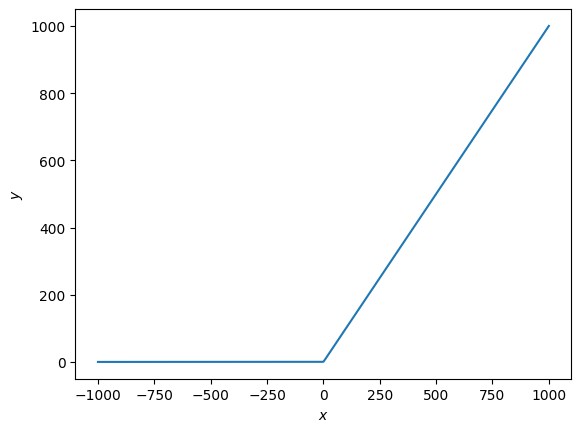

In [15]:
# do mashin exisate
xs = np.linspace(-1000,1000, 1000)
lse = mf.my_LSE(xs)
lse_der = mf.my_LSE_der(xs)

# plotting results
my_plt.plot_LSE(xs, lse)

## Softmax
### Задание
1. Докажите асимптотику softmax при $x\to\infty$.
2. Объясните, почему функция softmax вычисляеться значительно точнее, чем мы оценили? Что мы упустили?
3. В выкладках выше мы игнорировали погрешность округления. Что измениться, если ее учесть? 
4. Проведите оценки погрешности вычисления функции $LSE$. Составьте таблицу погрешностей промежуточных вычислений.

### Решение
1. $$ \underset{x\to \infty}{\lim} \frac{e^x}{1+e^x} = \underset{x\to \infty}{\lim} \frac{1}{1+e^{-x}} = 1$$

2. Дело в том, что мы делаем оценку сверху, оценивая независимо числитель и знаменатель. Это конечно верно, но оценка получается слишком далекой от правды, когда числитель и знаменатель имеют одинаковую асимптотику. Поэтому для более точной оценки, надо честно посчитать производную и соответственно $\kappa_f$:

$$\kappa_f(x)=\bigg|\frac{f'(x)x}{f(x)}\bigg| = \bigg|\frac{x}{1+e^x}\bigg| \longrightarrow 0 $$

отсюда мы видим что влияние погрешности аргумента на самом деле становится пренебрежимо малым при больших аргументах, поэтому softmax вычисляется так точно.

3. 
$$\sigma \text{LSE} = \bigg| \frac{xe^x}{1+e^x} \bigg| \varepsilon \underset{x\to\infty}{\longrightarrow} |x|\varepsilon$$

Поскольку при больших аргументах LSE почти совпадает с тождественной функцией, то и погрешность на больших числах логичным образом стремится к погрешности аргумента. При этом при отрицательных аргументах, значение функции почти не отличаеся от 0 - фиксированного значения,что тоже отражается:

$$\sigma \text{LSE} = \bigg| \frac{x}{1+e^{-x}} \bigg| \varepsilon = \frac{|x|}{1+e^{|x|}}\varepsilon \underset{x\to-\infty}{\longrightarrow} 0$$

4. Оценим погрешность вычисления функции $LSE(x)$ 

|   $a$  |   $\Delta a$   |  $\delta a$ |
|--------|----------------|-------------|
| $x$  | $\epsilon x$  |   $\epsilon$ |
| $e^x$ | $e^x \cdot \|x\| \epsilon$  |  $\|x\| \epsilon$ |
| $(e^x)^*$ | $e^x(\|x\|+1 )\epsilon$  |  $(\|x\|+ 1)\epsilon$ |
| $ 1+e^x$ | $(1+e^x) \cdot (\|x\|+1 )\epsilon$  |  $(\|x\|+ 1)\epsilon$ |
| $(1+e^x)^*$ | $e^x(\|x\|+2)\epsilon$ | $(\|x\|+2)\epsilon$ |
| $ \ln(1+e^{x})$ | $\delta_{1+e^{x}} \cdot \ln(1+e^{x})$ | $\frac{(\|x\|+2)\epsilon}{\|\ln(x)\|}$|
| $ (\ln(1+e^{x}))^*$ | $\delta_{(1+e^{x})^*} \cdot \ln(1+e^{x})$ | $\frac{(\|x\|+2)\epsilon}{\|\ln(x)\|} + \epsilon$|